In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import os 
warnings.filterwarnings('ignore') 

import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm

from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern, RBF
from sklearn.preprocessing import MinMaxScaler

os.chdir("../../")
plt.style.use("mpl_style/matplotlib.rc")

from src.utils import XY_from_csv, random_sampling_no_replace, load_ternary_data
from src.acquisition import run_acquisition
from src.algorithms import MultibandUnion, ConditionalMultiband, MultibandIntersection, GlobalOptimization1D, ParetoFront, Wishlist, PercentileSet1D
from src.models import MGPR, fit_matern_hypers
from src.metrics import get_n_obtained, get_jaccard_posterior
from src.plotting import plot_final_metrics, plot_iteration_results, plot_algo_true_function


Load / download datasets for ternary phase diagram of Fe-Ni-Co: 

References: 

Yoo, Young-kook et al. “Identification of amorphous phases in the Fe–Ni–Co ternary alloy system using continuous phase diagram material chips.” Intermetallics 14 (2006): 241-247 (https://www.sciencedirect.com/science/article/pii/S096697950500186X).
Alex Wang, Haotong Liang, Austin McDannald, Ichiro Takeuchi, Aaron Gilad Kusne, Benchmarking active learning strategies for materials optimization and discovery, Oxford Open Materials Science, Volume 2, Issue 1, 2022, itac006, https://doi.org/10.1093/oxfmat/itac006 (https://academic.oup.com/ooms/article/2/1/itac006/6637521).



In [2]:
X, Y = load_ternary_data('datasets/FeCoNi_benchmark_dataset_220501a.mat')

n_features, n_properties = X.shape[1], Y.shape[1]

print("Size of the design space: {}, Size of the measured property space: {}".format(X.shape, Y.shape))

Size of the design space: (921, 2), Size of the measured property space: (921, 2)


Normalize datasets (in order to get GP models to fit well)

In [3]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

X_unnorm, Y_unnorm = x_scaler.inverse_transform(X), y_scaler.inverse_transform(Y)


Define various experimental goals via algorithms. Here, we select a Wishlist Algorithm (disjoint set of multibands). Experiment with uncommenting different algorithms! In addition, please refer to tutorial <code>tutorial_1_expressing_a_goal_as_an_algorithm</code> for guidance on how to define a custom algorithm.  

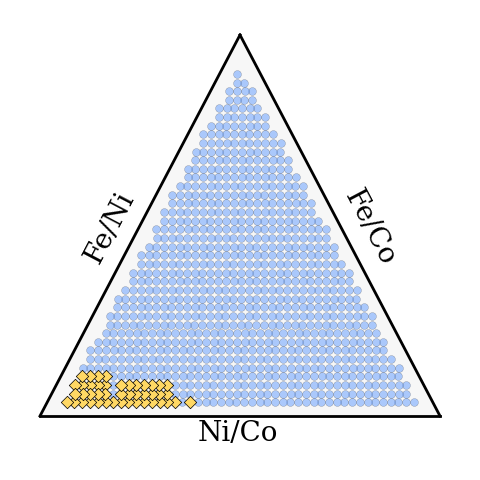

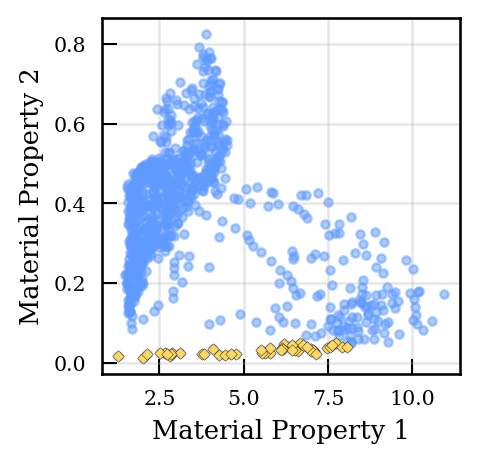

In [11]:
user_algo_params = {'scalers': scalers, 
                    'threshold_bounds_list': [[[0.0, 2.0], [0.00, 0.2]], [[8.0, 10.0], [0.0, 0.1]], [[5.0, 8.0], [0.3, 0.5]]]}


algorithm = Wishlist(user_algo_params=user_algo_params)


## this is a variant of a pareto front which allows for robustness for each property [0.00001, 0.00001] will give a traditional pareto front; experiment with increasing!
# algorithm = ParetoFront(tolerance_list = [0.01, 0.01],  max_or_min_list = [1, 1], scalers = scalers)

plot_algo_true_function(algorithm, x_scaler, y_scaler, X, Y)

Get the ground-truth target subset

In [12]:
all_ids = list(np.arange(0, len(X)))  # integer mapping design space
true_target_ids = algorithm.identify_subspace(f_x=Y, x=X) 

Specify a GP kernel. Note, in order to use a different kernel, the code below has to be modified to the new kernel AND <code>fit_matern_hypers</code> in src/utils.py needs to be appropriately modified. The reason for this is to ensure that the n_posterior_sample GP models all have identical kernels (for InfoBAX/SwitchBAX).

In [13]:
kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
kernel_initial_list = n_properties * [kernel_initial]

Config params: 

Note: <code>fixed_hypers = True</code> fits the GP hyperparameters on the entire dataset. For more a more practical scenario, choose <code>fixed_hypers = False</code> which will perform adaptive hyperparameter fitting.

In [18]:
plotting = True
prevent_requery = True
n_posterior_samples = 15 # relevant for InfoBAX and mixedBAX 
n_initial = 1 # Number of initial datapoints 
n_iters = 50 # Number of measurements to be performed 
plot_frequency = n_iters - 1
n_repeats = 3 # Repeats with different dataset initializations 
fixed_hypers = False 
adaptive_fit_freq = 10

The code below simulates data acquisition for a specific experimental goal using the following acquisition functions: SwitchBAX, MeanBAX, InfoBAX and US. Adding additional repeats selects different initial starting training points. 

Using strategy: SwitchBAX


 98%|█████████▊| 49/50 [00:34<00:01,  1.06s/it]

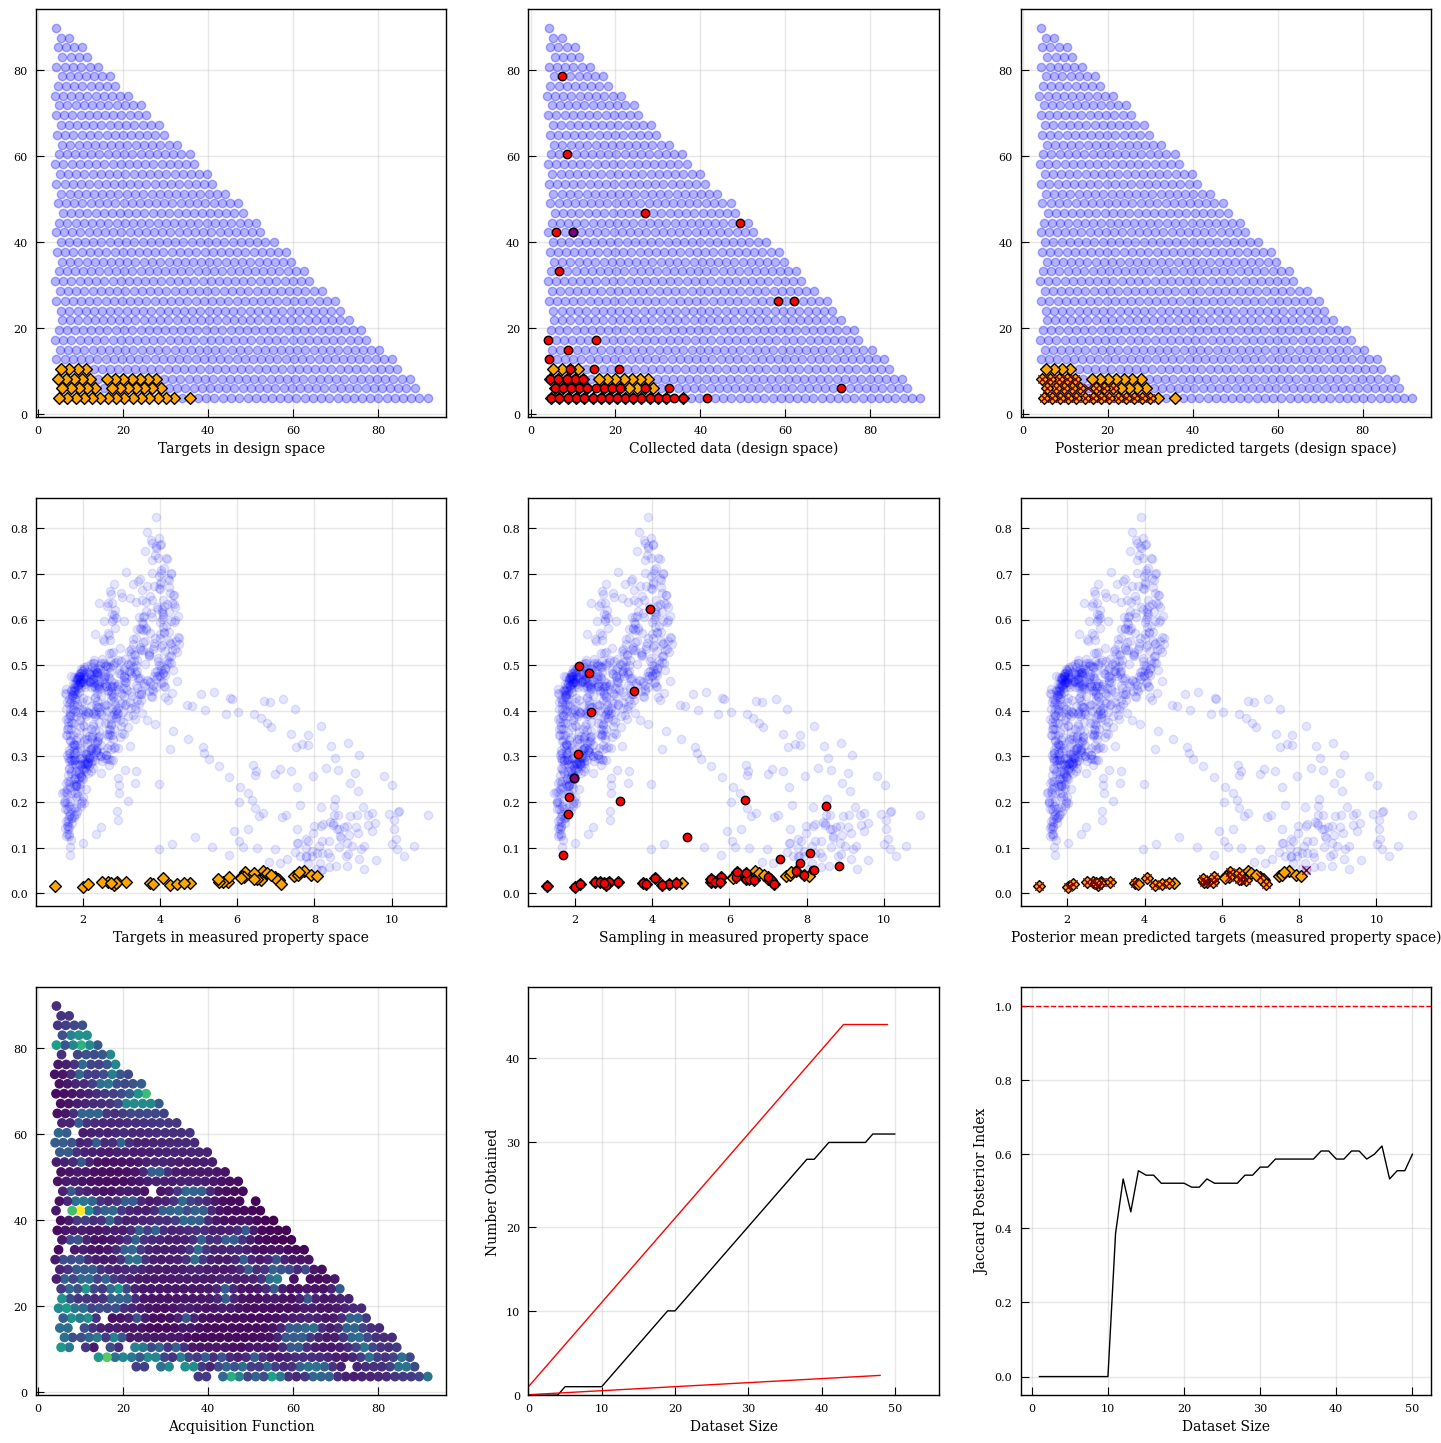

 92%|█████████▏| 46/50 [00:10<00:00,  4.89it/s]

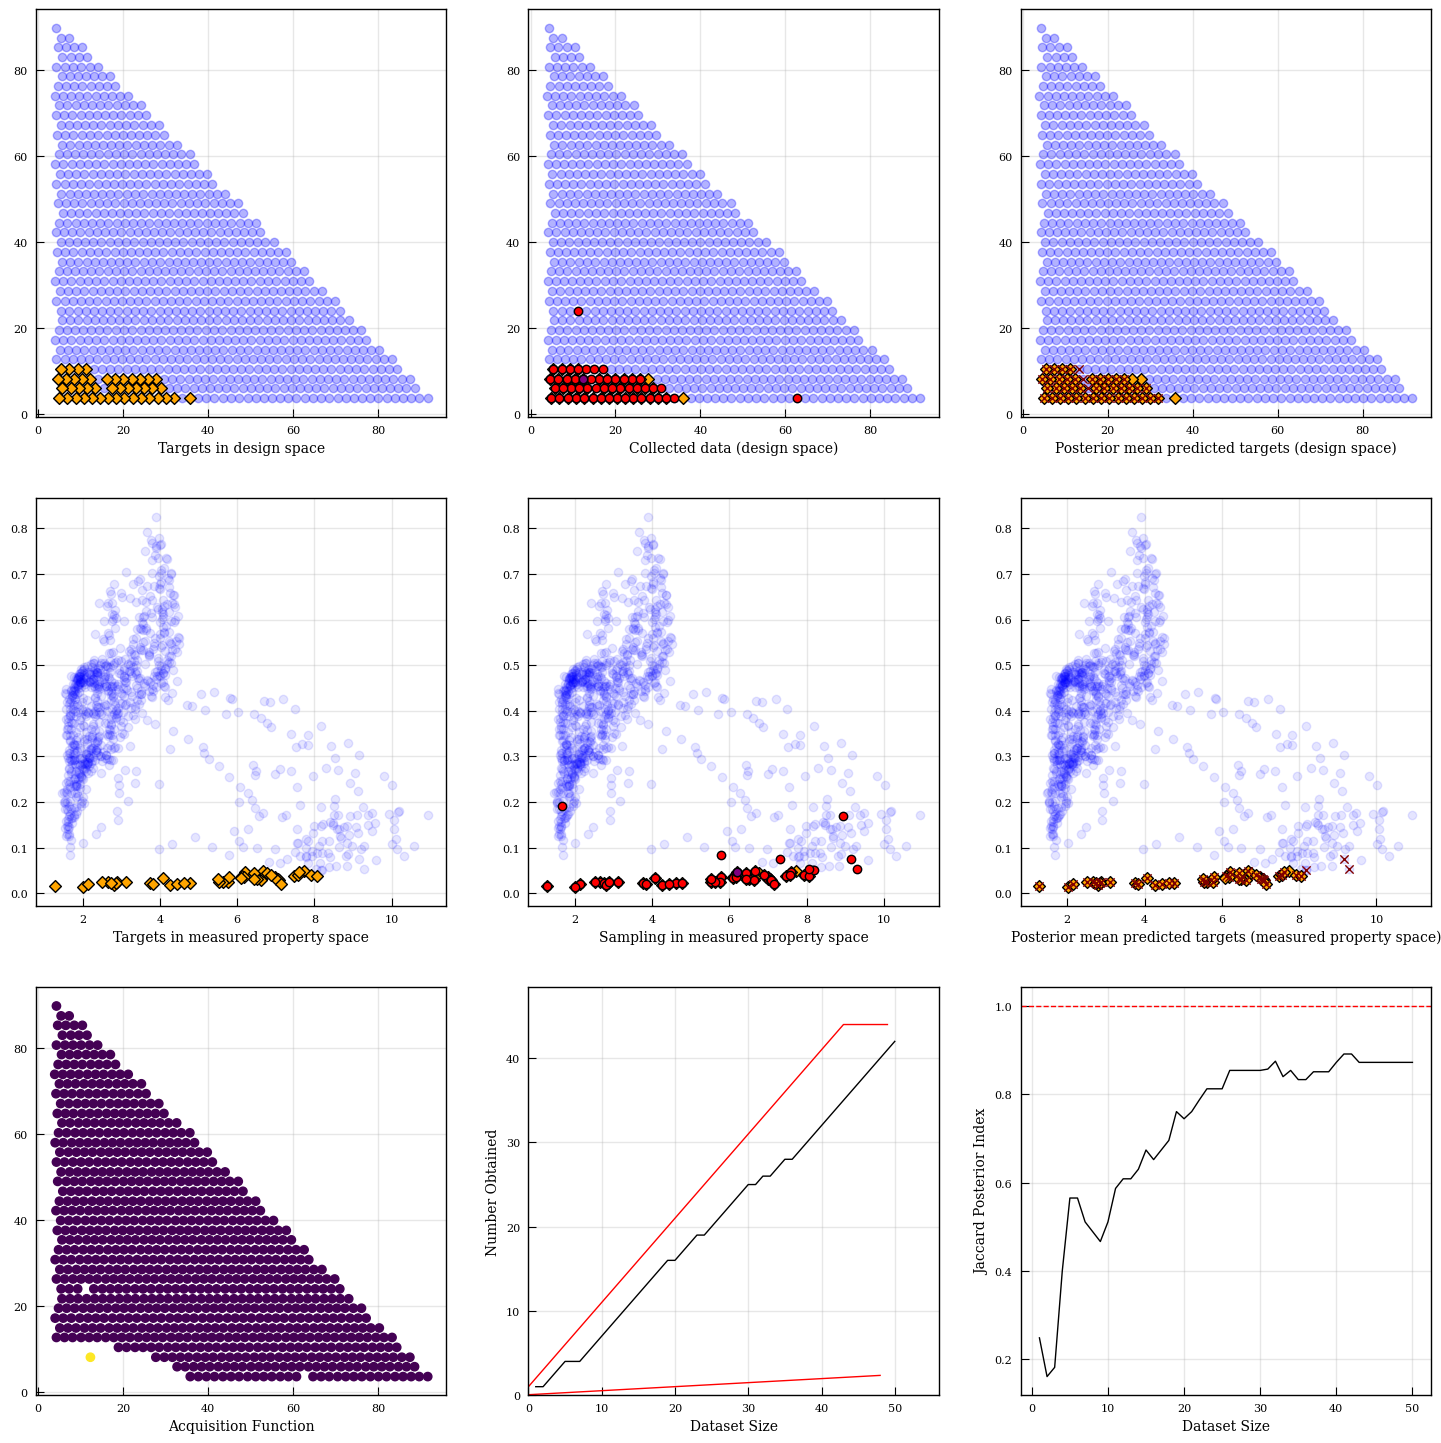

 98%|█████████▊| 49/50 [00:34<00:00,  1.10it/s]

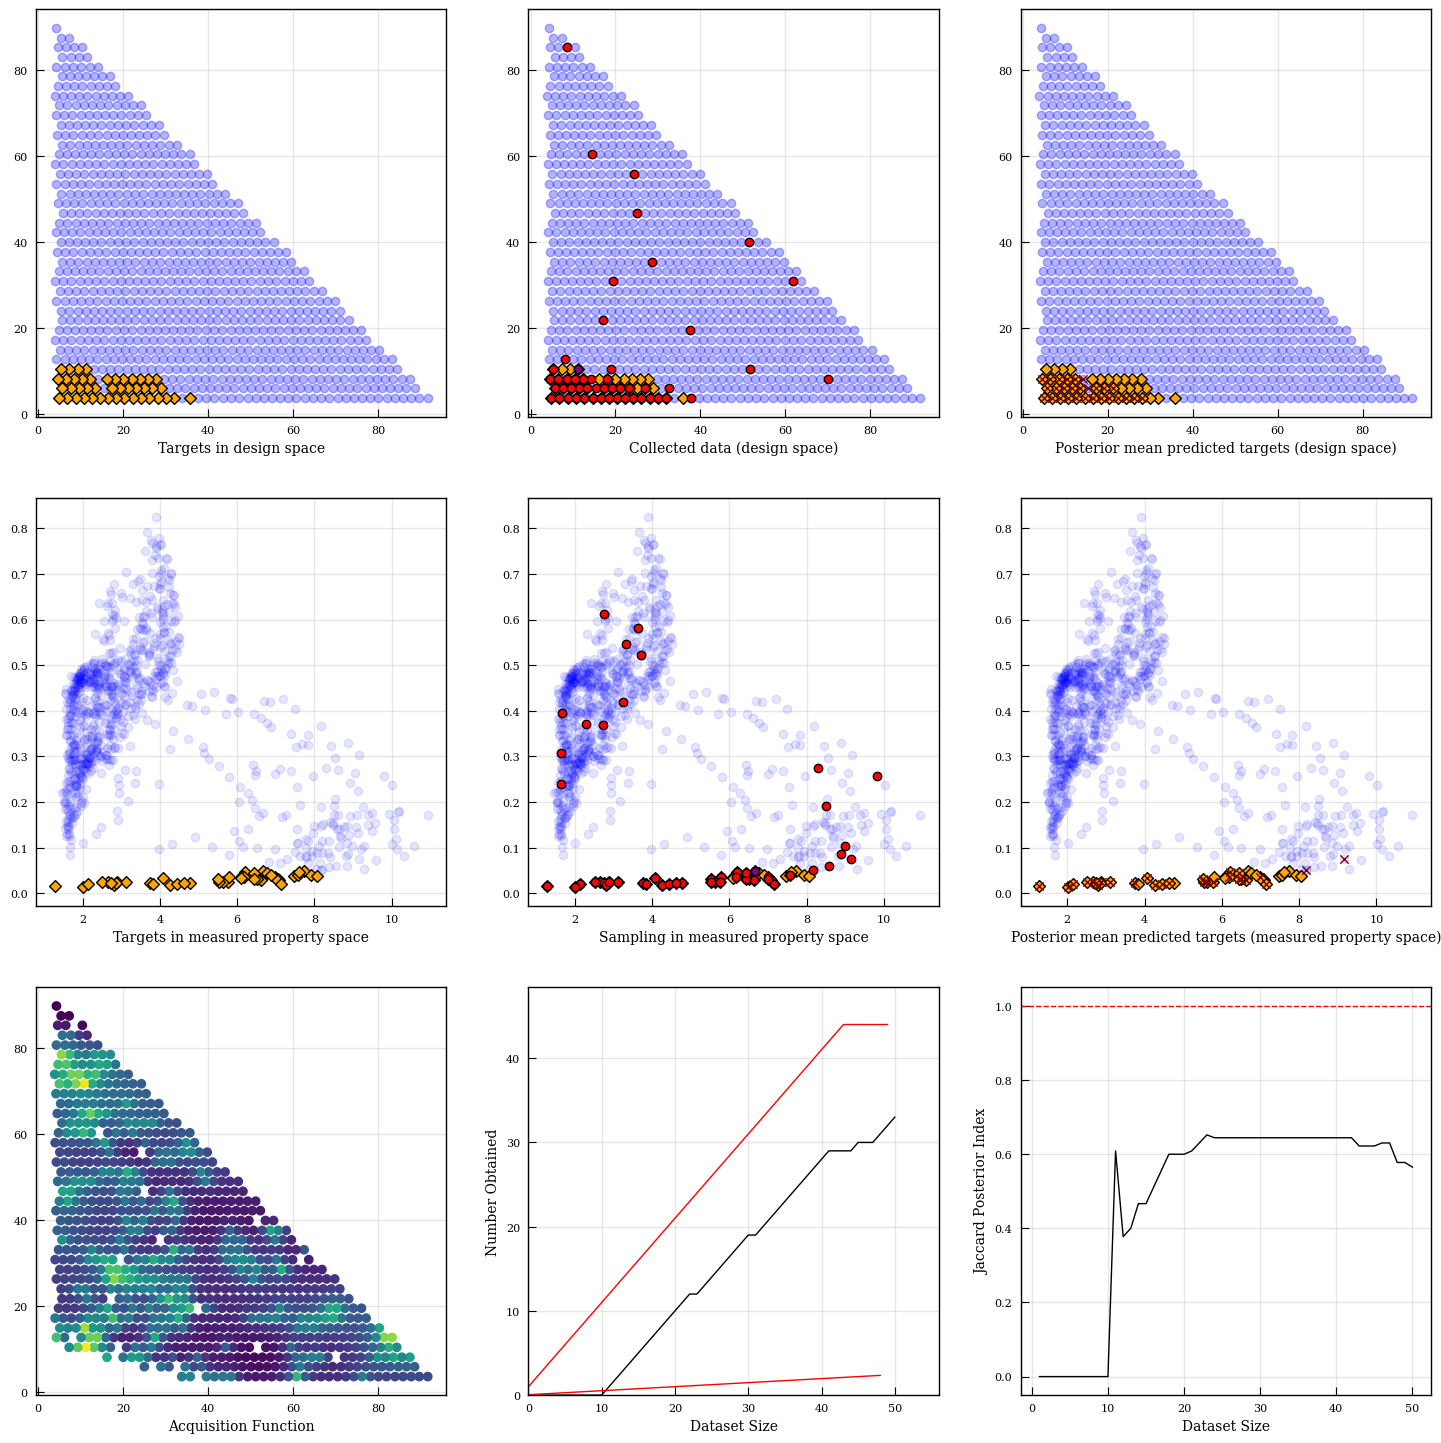

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Using strategy: MeanBAX


 92%|█████████▏| 46/50 [00:11<00:00,  4.07it/s]

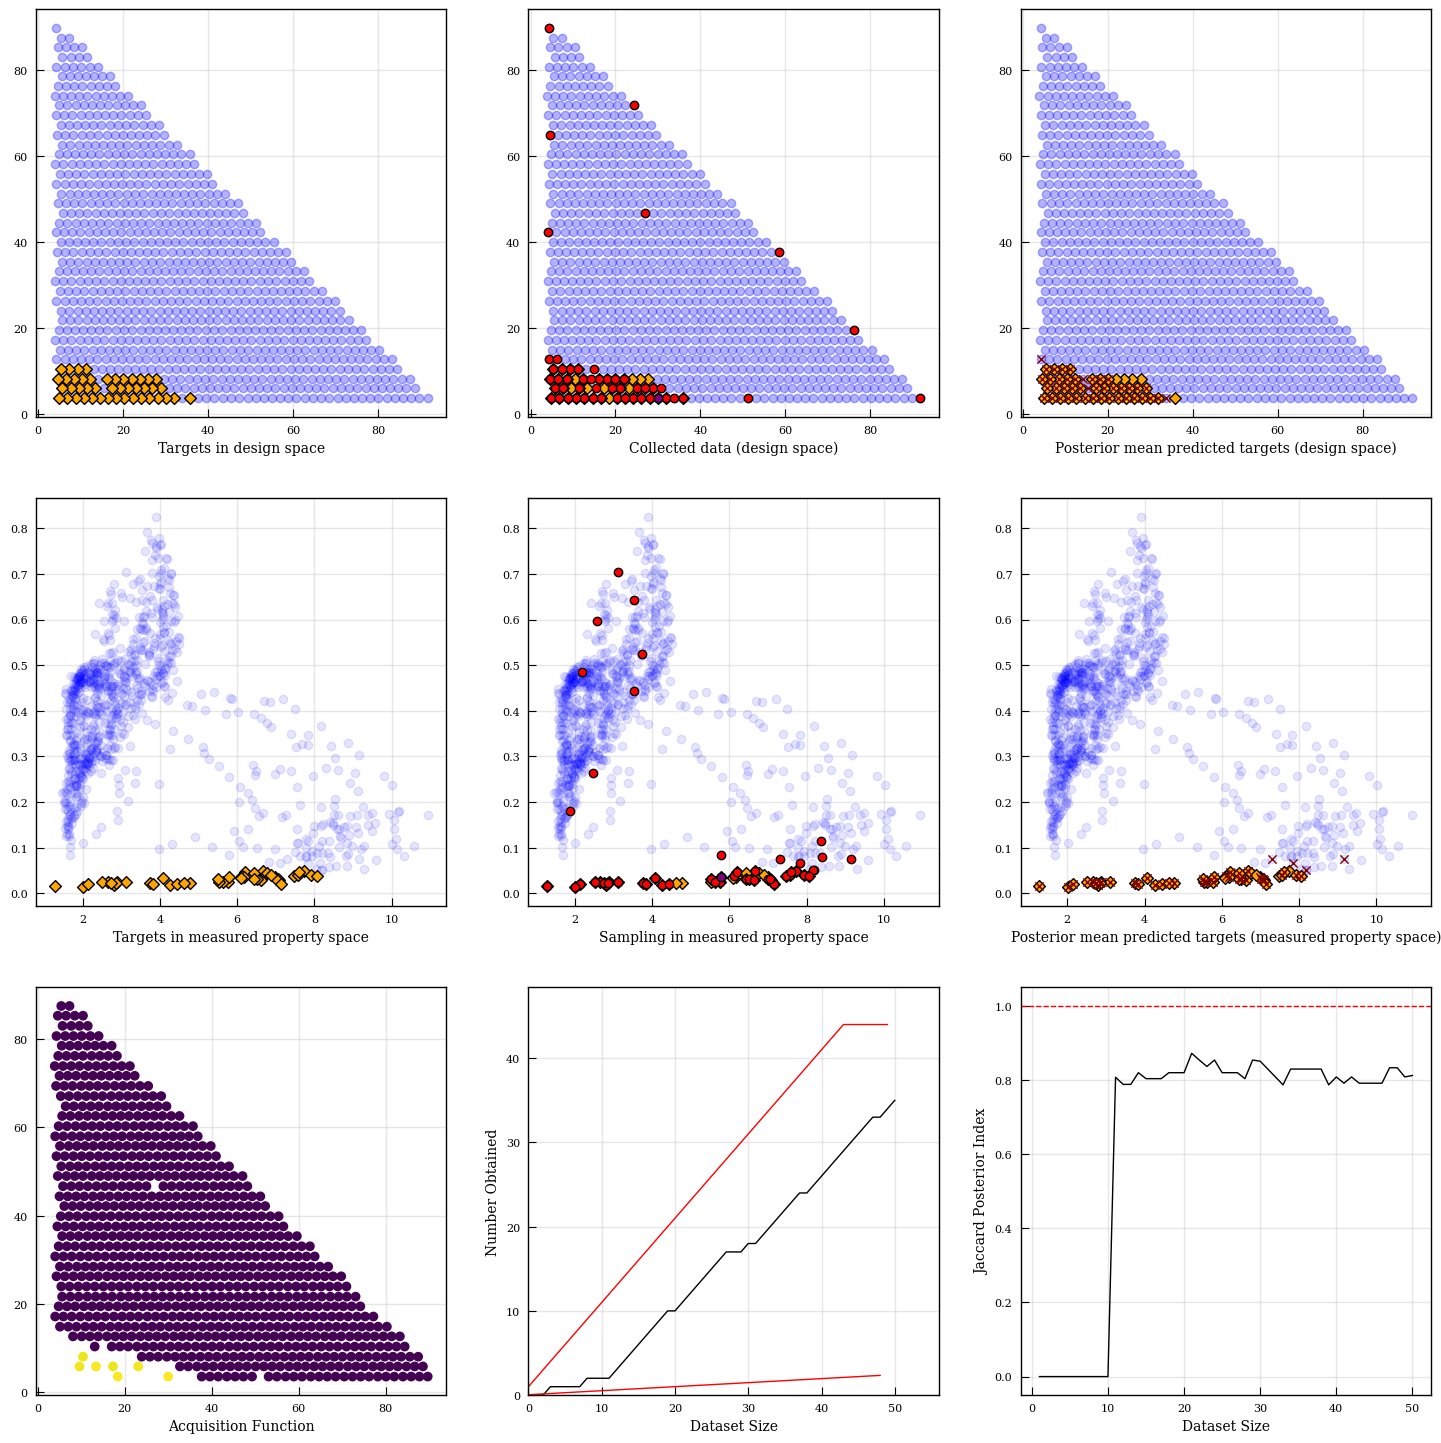

 92%|█████████▏| 46/50 [00:10<00:00,  4.81it/s]

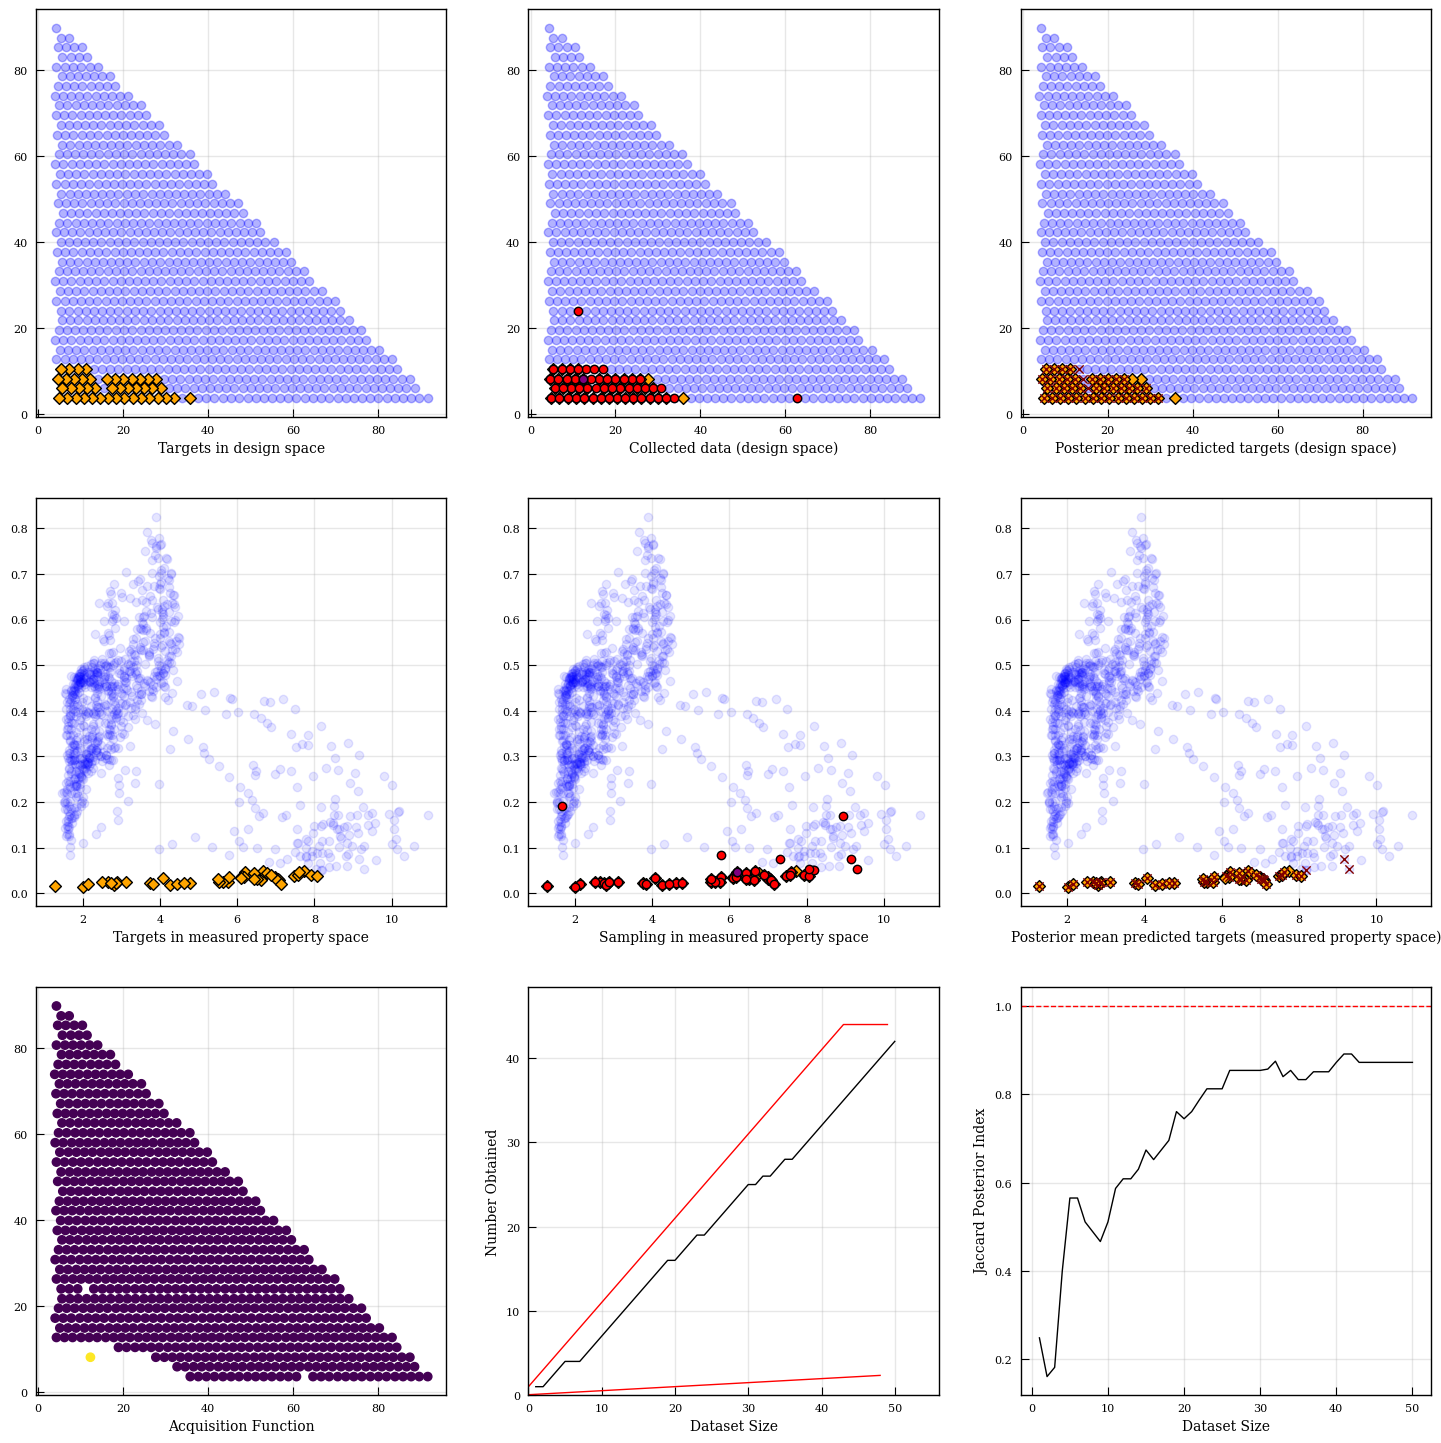

 92%|█████████▏| 46/50 [00:10<00:00,  4.55it/s]

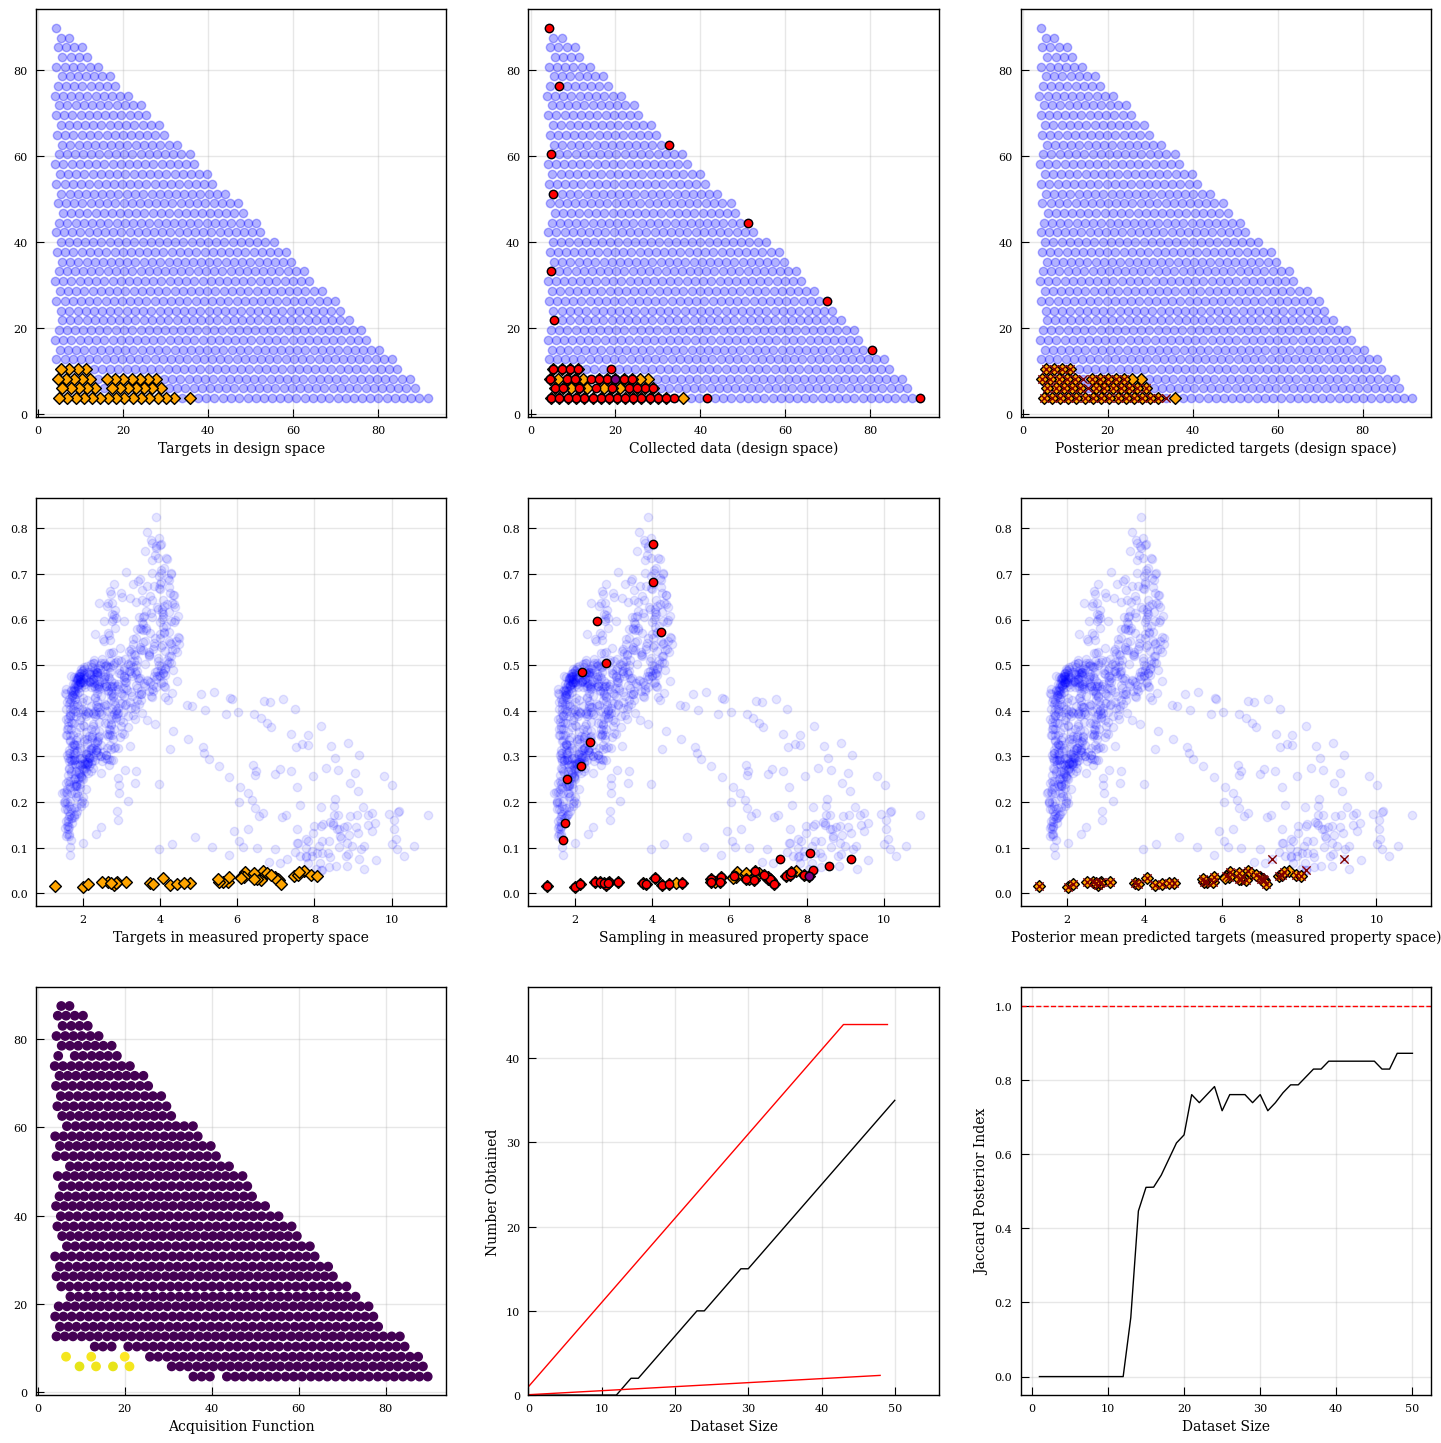

100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


Using strategy: US


 72%|███████▏  | 36/50 [00:08<00:03,  4.40it/s]

In [19]:
metrics = {
    "SwitchBAX": {"n_obtained": [], "jaccard_posterior_index": [], "switch_strategy": []},
    "US": {"n_obtained": [], "jaccard_posterior_index": [], "switch_strategy": []},
    "MeanBAX": {"n_obtained": [], "jaccard_posterior_index": [], "switch_strategy": []},
    "InfoBAX": {"n_obtained": [], "jaccard_posterior_index": [], "switch_strategy": []},
}

# Baseling for random sampling without replacement (expectation of hypergeometric distribution)
random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

# Baseline for best possible acquisition (i.e. acquire a target point at each iteration; need an "oracle" to do this)
if n_iters <= len(true_target_ids):
    best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
else:
    best_possible_n_obtained = list(np.arange(n_initial, len(true_target_ids))) + list(
        len(true_target_ids) * np.ones(n_iters + n_initial - len(true_target_ids))
    )

# Acquisition functions that use BAX for subset estimation
strategies = ["SwitchBAX", "MeanBAX", "US", "InfoBAX"]


# Calculate hypers based on the entire dataset; this is not possible in a real experiment but allows us to compare acquisition fn to acquisition fn
if fixed_hypers: kernel_list = fit_matern_hypers(x_train=X, y_train=Y, kernel_list=kernel_initial_list, n_restarts_optimizer=1)

for strategy in strategies:
    print("Using strategy: {}".format(strategy))
    
    for j in range(n_repeats):  # to see variance w.r.t initial datapoint choice
        np.random.seed(j) # make sure all strategies get same initial points
        train_indices = list(np.random.choice(all_ids, n_initial))
        x_train = X[train_indices]
        y_train = Y[train_indices]

        collected_ids = list(train_indices)
        n_obtained_list = []
        jaccard_posterior_list = []
        switch_list = [] 

        for i in tqdm(range(n_iters)):
            # Adaptive hyperparameter fitting
            if (i % adaptive_fit_freq == 0) and (fixed_hypers == False):
                kernel_list = fit_matern_hypers(x_train=x_train, y_train=y_train, kernel_list=kernel_initial_list)
            
            # Define GP model with fixed, fitted hypers. Note, we need this so that all the n_posterior models for InfoBAX have the same kernel
            multi_gpr = MGPR(kernel_list=kernel_list)

            # Acquire next index
            x_train, y_train, model, collected_ids, acquisition_function, switch_strategy = run_acquisition(
                x_train, y_train, X, Y, strategy, algorithm, multi_gpr, collected_ids, n_posterior_samples
            )

            # Calculate metrics
            posterior_mean, posterior_std = model.predict(X)
            predicted_target_ids = algorithm.identify_subspace(f_x = posterior_mean, x=X)
            n_obtained_list.append(get_n_obtained(collected_ids, true_target_ids))
            jaccard_posterior_list.append(get_jaccard_posterior(predicted_target_ids, true_target_ids))
            switch_list.append(switch_strategy)

            if (i % plot_frequency == 0) and (plotting) and (i != 0):
                plot_iteration_results(
                    X,
                    Y,
                    x_scaler,
                    y_scaler,
                    collected_ids,
                    true_target_ids,
                    predicted_target_ids,
                    acquisition_function,
                    n_obtained_list,
                    jaccard_posterior_list,
                    best_possible_n_obtained,
                    random_sampling,
                    n_initial
                )

        metrics[strategy]["n_obtained"].append(n_obtained_list)
        metrics[strategy]["jaccard_posterior_index"].append(jaccard_posterior_list)
        metrics[strategy]["switch_strategy"].append(switch_list)

        # Plot whether strategy was switched
        # plt.figure(figsize=(10,3))
        # plt.step(np.arange(n_initial, n_initial + n_iters), metrics[strategy]['switch_strategy'][0])
        # plt.ylabel('Exploit/Explore')
        # plt.xlabel('Dataset Size')
        # plt.show()
plot_final_metrics(n_iters, metrics, strategies, best_possible_n_obtained, random_sampling)